# How to separate your credentials, secrets, and configurations from your source code with environment variables

## <a id="intro"></a>Introduction

As a modern application, your application always deal with credentials, secrets and configurations to connect to other services like Authentication service, Database, Cloud services, Microservice, ect. It is not a good idea to keep your username, password and other credentials hard code in your source code as your credentials may leak when you share or publish the application. You need to delete or remark those credentials before you share the code which adds extra work for you. And eventually, you may forgot to do it.

The services configurations such as API endpoint, Database URL should not be embedded in the source code too. The reason is every time you change or update the configurations you need to modify the code which may lead to more errors. 

How should we solve this issue?

### <a id=""></a>Store config in the environment

The [Twelve-Factor App methodology](https://12factor.net/) which is one of the most influential pattern to designing scalable software-as-a-service application. The methodology [3rd factor](https://12factor.net/config) (aka Config principle) states that configuration information should be kept as environment as environment variables and injected into the application on runtime.

>The twelve-factor app stores config in environment variables (often shortened to env vars or env). Env vars are easy to change between deploys without changing any code; unlike config files, there is little chance of them being checked into the code repo accidentally; and unlike custom config files, or other config mechanisms such as Java System Properties, they are a language- and OS-agnostic standard.

### Introduction to .ENV file and dotenv

The dotenv method lets the application loads variables from a ```.env``` file into environment/running process the same way as the application load variables from environment variables. The application can load or modify the environment variables from the OS and ```.env``` file with a simple function call.

[dotenv](https://github.com/bkeepers/dotenv) is a library that originates from [Ruby](https://www.ruby-lang.org/en/) developers (especially the [Ruby on Rails](https://rubyonrails.org/) framework) and has been widely adopted and ported to many programming languages such as [python-dotenv](https://github.com/theskumar/python-dotenv), [dotenv-java](https://github.com/cdimascio/dotenv-java), [Node.js](https://github.com/motdotla/dotenv), etc. 

The ```.env``` file is a simple text file locates at the root of the project with a key-value pair setting as the following:

```
# DB
DB_USER=User
DB_PASSWORD=MyPassword
# Cloud
CLOUD_URL=192.168.1.1
```

**Caution**:
You *should not* share this ```.env``` file to your peers or commit/push it to the version control. You should add the file to the ```.gitignore``` file to avoid adding it to a version control or public repo accidentally.

This notebook application demonstrate how to use python-dotenv library to store and read the [Refinitiv Data Platform (RDP) APIs](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-apis) credentials and configurations, then request the RDP data.

### <a id="whatis_rdp"></a>What is Refinitiv Data Platform (RDP) APIs?

The [Refinitiv Data Platform (RDP) APIs](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-apis) provide various Refinitiv data and content for developers via easy to use Web based API.

RDP APIs give developers seamless and holistic access to all of the Refinitiv content such as Historical Pricing, Environmental Social and Governance (ESG), News, Research, etc and commingled with their content, enriching, integrating, and distributing the data through a single interface, delivered wherever they need it.  The RDP APIs delivery mechanisms are the following:
* Request - Response: RESTful web service (HTTP GET, POST, PUT or DELETE) 
* Alert: delivery is a mechanism to receive asynchronous updates (alerts) to a subscription. 
* Bulks:  deliver substantial payloads, like the end of day pricing data for the whole venue. 
* Streaming: deliver real-time delivery of messages.

This example project is focusing on the Request-Response: RESTful web service delivery method only.  

For more detail regarding Refinitiv Data Platform, please see the following APIs resources: 
- [Quick Start](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-apis/quick-start) page.
- [Tutorials](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-apis/tutorials) page.
- [RDP APIs: Introduction to the Request-Response API](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-apis/tutorials#introduction-to-the-request-response-api) page.
- [RDP APIs: Authorization - All about tokens](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-apis/tutorials#authorization-all-about-tokens) page.


## Importing Libraries

The first step is importing all required libraries including the python-dotenv, requests, Pandas, etc.

In [1]:
import os
from dotenv import load_dotenv
import requests
import pandas as pd
import numpy as np

You should save a text file with **filename** `.env` or Environment Variables having the following configurations:

```
# RDP Core Credentials
RDP_USER=<Your RDP username>
RDP_PASSWORD=<Your RDP password>
RDP_APP_KEY=<Your RDP appkey>

# RDP Core Endpoints
RDP_BASE_URL = https://api.refinitiv.com
RDP_AUTH_URL=/auth/oauth2/v1/token
RDP_ESG_URL=/data/environmental-social-governance/v2/views/scores-full
```

You can use the python-dotenv library in IPython environment such as Jupyter Notebook or Jupyter Lab by executing the following Magic statements. 

```
%load_ext dotenv

# Use find_dotenv to locate the file
%dotenv
```

By default, it will use find_dotenv to search for a .env file in a current directory location. Please note that the OS/System's environment variables always override ```.env``` configurations by default as the following example. 

Let's test with the ```USERNAME``` value which will be loaded from your System's environment variables.


In [2]:
%load_ext dotenv
%dotenv

print('User: ', os.getenv('USERNAME'))

User:  U8004042


Next, the notebook application uses ```os.getenv``` statement to get RDP APIs Auth service endpoint and user's RDP credentials configurations from environment.

In [61]:
# Get RDP Token service information from Environment Variables
base_URL = os.getenv('RDP_BASE_URL')
auth_endpoint = base_URL + os.getenv('RDP_AUTH_URL') 

# Get RDP Credentials information from Environment Variables
username = os.getenv('RDP_USER')
password = os.getenv('RDP_PASSWORD')
app_key = os.getenv('RDP_APP_KEY')

Refinitiv Data Platform entitlement check is based on OAuth 2.0 specification. The first step of an application workflow is to get a token from RDP Auth Service, which will allow access to the protected resource, i.e. data REST API's. 

We create the RDP Auth Service reqeust message with additional variables in the next step.

In [95]:
# RDP Auth Services request message variables

client_secret = ''
scope = 'trapi'
auth_obj = None

# -- Init and Authenticate Session
auth_request_msg = {
    'username': username ,
    'password': password ,
    'grant_type': "password",
    'scope': scope,
    'takeExclusiveSignOnControl': "true"
}

Now notebook is ready to send the HTTP request message with the *requests* library. 

It keeps the response JSON message which contains the RDP Access Token information in the *auth_obj* variable.

In [101]:
# Authentication with RDP Auth Service
try:
    response = requests.post(auth_endpoint, headers = {'Accept':'application/json'}, data = auth_request_msg, auth = (app_key, client_secret))
except Exception as exp:
    print('Caught exception: %s' % str(exp))

if response.status_code == 200:  # HTTP Status 'OK'
    print('Authentication success')
    auth_obj = response.json() 
else:
    print('RDP authentication result failure: %s %s' % (response.status_code, response.reason))
    print('Text: %s' % (response.text))

Authentication success


After the application received the Access Token (an authorization token) from RDP Auth Service, all subsequent REST API calls will use this token to get the data. The application needs to input Access Token via *Authorization* HTTP request message header as shown below. 
- Header: 
    * Authorization = ```Bearer <RDP Access Token>```

Please notice *the space* between the ```Bearer``` and ```RDP Access Token``` values.

The next step is requesting ESG (Environmental, Social, and Governance) data from RDP. We use the ESG scores-full API endpoint which provides full coverage of Refinitiv's proprietary ESG Scores with full history for consumers as an example API.

We get the RDP ESG Service API endpoint from a ```.env``` file.

In [102]:
# Get RDP Token service information from Environment Variables
esg_url = base_URL + os.getenv('RDP_ESG_URL') 

In [103]:
# ESG Score Full request messages variables

universe = 'TSLA.O'
payload = {'universe': universe}
esg_object = None

In [104]:
# Request data for ESG Score Full Service
try:
    response = requests.get(esg_url, headers={'Authorization': 'Bearer {}'.format(auth_obj['access_token'])}, params = payload)
except Exception as exp:
    print('Caught exception: %s' % str(exp))

if response.status_code == 200:  # HTTP Status 'OK'
    print('Receive ESG Data from RDP APIs success')
    #print(response.json())
    esg_object=response.json()
else:
    print('RDP APIs: ESG data request failure: %s %s' % (response.status_code, response.reason))
    print('Text: %s' % (response.text))

Receive ESG Data from RDP APIs success


Once the we receive ESG Data from RDP, we can convert the data from JSON object to a Pandas Dataframe by the following steps:
1. Gets the data and column name from JSON object and then re-constructs it as a new map object. 
2. Converts the JSON's data field to the numpy array.
3. Create a new Pandas Dataframe from the numpy data array and headers map.

In [68]:
headers=esg_object['headers']
#Get column headers/titles using lambda
titles=map(lambda header:header['title'], headers)
        
dataArray=np.array(esg_object['data'])
df=pd.DataFrame(data=dataArray,columns=titles)

In [118]:
df.head()

,Instrument,Period End Date,ESG Score,ESG Combined Score,ESG Controversies Score,Social Pillar Score,Governance Pillar Score,Environment Pillar Score,Resource Use Score,Emissions Score,...,Environmental Innovation Score Grade,Workforce Score Grade,Human Rights Score Grade,Community Score Grade,Product Responsibility Score Grade,Management Score Grade,Shareholders Score Grade,CSR Strategy Score Grade,ESG Reporting Scope,ESG Period Last Update Date
0,TSLA.O,2019-12-31,58.254003,33.502002,8.75,45.926325,64.77289,68.615899,68.71345,45.639535,...,A-,B-,D+,A-,C+,B+,B-,B,100,2021-07-31T00:00:00
1,TSLA.O,2018-12-31,50.644625,27.59504,4.545455,43.005873,29.804808,74.836149,73.701299,47,...,A+,C-,C-,A-,B-,C-,D+,C+,100,2020-11-06T00:00:00
2,TSLA.O,2017-12-31,38.474367,30.82255,23.170732,29.812015,28.348069,56.260383,18.560606,30.859375,...,A,D,C-,C+,C,C-,C-,D+,None,2020-09-18T00:00:00
3,TSLA.O,2016-12-31,32.830778,28.134139,23.4375,23.480904,39.308764,39.594166,12.719298,25.229358,...,B,C-,D-,C+,C,C+,C,D+,None,2020-09-18T00:00:00
4,TSLA.O,2015-12-31,28.066419,28.066419,100,22.770368,24.749475,36.887599,10.39604,20.103093,...,B,D+,D-,B-,C,D+,C+,D+,None,2020-09-18T00:00:00


## Plotting Graph

Then we can plot a graph of the ESG Dataframe object using [matplotlib library](https://matplotlib.org/).

In [111]:
# Import matplotlib
from matplotlib import pyplot as plt

The ESG Data from RDP contains a lot of information, so we will create a new Dataframe object from the original Dataframe to compare only *ESG Score*, *ESG Combined Score* and *ESG Controversies Score* fields.

In [114]:
df_plot=pd.DataFrame(df,columns=['Instrument','Period End Date','ESG Score','ESG Combined Score','ESG Controversies Score'])
df_plot.head()

,Instrument,Period End Date,ESG Score,ESG Combined Score,ESG Controversies Score
0,TSLA.O,2019-12-31,58.254003,33.502002,8.75
1,TSLA.O,2018-12-31,50.644625,27.59504,4.545455
2,TSLA.O,2017-12-31,38.474367,30.82255,23.170732
3,TSLA.O,2016-12-31,32.830778,28.134139,23.4375
4,TSLA.O,2015-12-31,28.066419,28.066419,100


The data for the Y-axis is the *Period End Date* field and the X-axis is the ESG scores fields. We want to display only the year (eg "2017", "2016") therefore we reformat the data in "Period End Date" column using below codes.

In [115]:
df_plot['Period End Date']= df_plot['Period End Date'].str.split('-').str[0]
df_plot.head(2)

,Instrument,Period End Date,ESG Score,ESG Combined Score,ESG Controversies Score
0,TSLA.O,2019,58.254003,33.502002,8.75
1,TSLA.O,2018,50.644625,27.59504,4.545455


Then sort data as ascending order.

In [116]:
df_plot.sort_values('Period End Date',ascending=True,inplace=True)

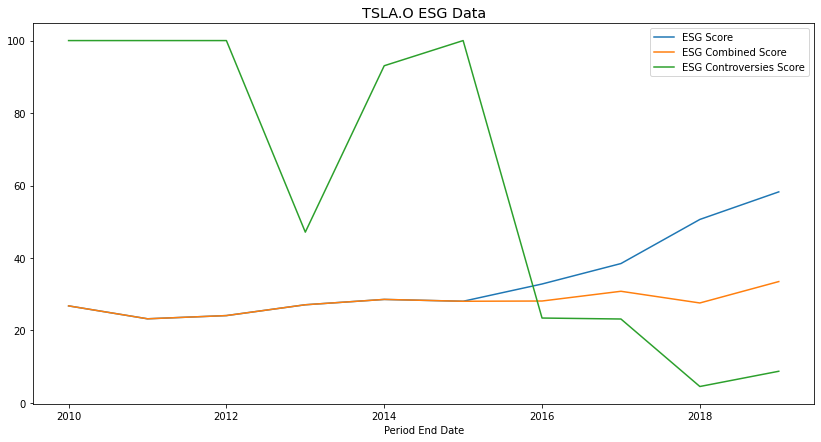

In [117]:
# Plotting a Graph

fig = plt.figure()

plt.ticklabel_format(style = 'plain')
plt.title('%s ESG Data' % (universe), color='black',fontsize='x-large')
ax = fig.gca()

df_plot.plot(kind='line', ax = fig.gca(),x='Period End Date', y=['ESG Score','ESG Combined Score','ESG Controversies Score'],figsize=(14,7) )
plt.show()

## Conclusion

The above code shows that you do not need to change the code if the RDP credentials or service endpoint is changed (example update the API version). We can just update the configurations in a ```.env``` file (or System environment variables) and re-run the application.